In [17]:
# Step 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load datasets
train_data = pd.read_csv('df_train.csv')
test_data = pd.read_csv('df_test.csv')

# Display the first few rows
train_data.head()


,date,price,bedrooms,grade,has_basement,living_in_m2,renovated,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,month,quartile_zone
0,2014-06-20,237000.0,3,7,False,120.77390,False,False,False,1,False,True,6,2
1,2015-04-20,1328000.0,5,9,True,310.29602,True,True,False,3,False,True,4,4
2,2014-08-13,790500.0,4,9,False,311.22505,False,False,False,2,True,False,8,4
3,2015-04-08,431000.0,4,9,False,282.42512,False,False,False,2,True,False,4,2
4,2015-02-11,199000.0,3,7,True,162.58025,False,False,False,2,True,True,2,2


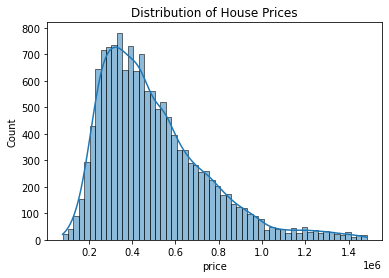

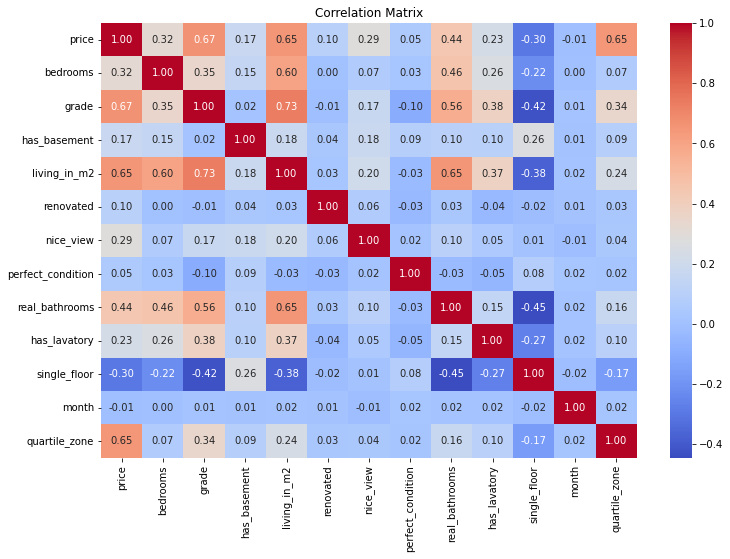

In [18]:
# Check summary statistics
train_data.describe()

# Check distribution of the target variable 'price'
sns.histplot(train_data['price'], kde=True)
plt.title("Distribution of House Prices")
plt.show()

# Correlation heatmap to explore relationships between features and target variable
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [19]:
# Check for missing values
train_data.isnull().sum().sort_values(ascending=False)

# Fill missing values (numerical features with median, categorical features with mode)
for col in train_data.select_dtypes(include=['float64', 'int64']).columns:
    train_data[col].fillna(train_data[col].median(), inplace=True)
for col in train_data.select_dtypes(include=['object']).columns:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)


In [20]:
# Select categorical and numerical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns
numerical_cols = train_data.select_dtypes(exclude=['object']).columns.drop('price')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [30]:
if 'living_in_m2' in train_data.columns:
    train_data['TotalSF'] = train_data['living_in_m2']


In [22]:
# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Define features and target variable
X = train_data.drop(columns=['price'])
y = train_data['price']

# Train/test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['bedrooms', 'grade', 'has_basement', 'living_in_m2', 'renovated',
       'nice_view', 'perfect_condition', 'real_bathrooms', 'has_lavatory',
       'single_floor', 'month', 'quartile_zone'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['date'], dtype='object'))])),
                ('model', LinearRegression())])

In [24]:
# Predict and evaluate
y_pred = pipeline.predict(X_valid)

# Calculate metrics
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 15075867537.735723
R^2 Score: 0.7388478137147598


In [25]:
# If needed, add 'TotalSF' feature to the test set as well
if 'living_in_m2' in test_data.columns:
    test_data['TotalSF'] = test_data['living_in_m2']

# Remove target column if it exists in the test dataset
X_test = test_data.drop(columns=['price'], errors='ignore')
test_predictions = pipeline.predict(X_test)


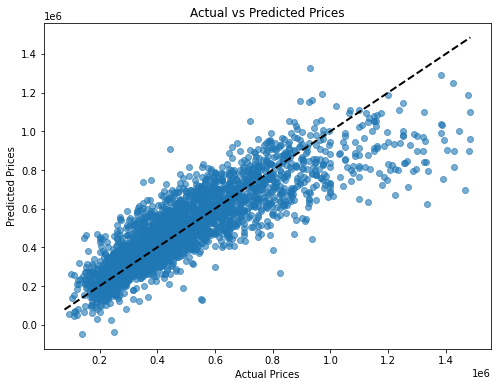

In [27]:
# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Line for perfect predictions
plt.show()

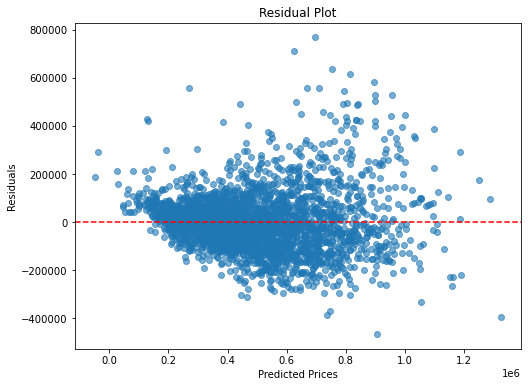

In [28]:
# Residual plot (errors)
residuals = y_valid - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

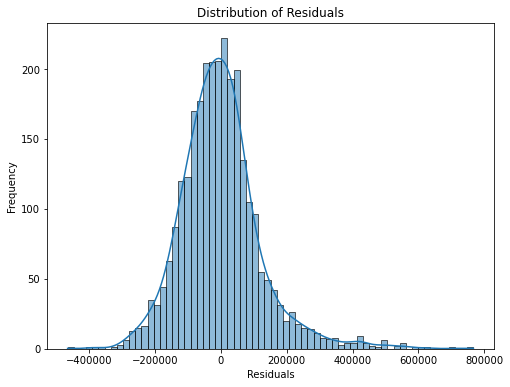

In [29]:
# Distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()